# IES nucleosome density difference analyses

### Input files
- file(s) containing IES IDs, IES lengths and read counts on IESs for experimental and control sampels. These files can be generated with the Prepare_input_data_for_nuc_den.ipynb jupyter notebook
- file containing IES IDs and IES retention scores of knockdowns used for filtering

#### Experimental Setup used for input files
MAC DNA of knockdown cells was purified and split into two. One half (called: DNA) was send to whole genome sequencing (WGS). The other half (called: DNase) was first treated with DNase to obtain mononucleosomes and then send for WGS. The sequencing reads were subjected to adaptor trimming (using the trimgalore module) and fastQC analysis. To count the reads mapping to IESs, the following scripts were apllied: The "DNA" reads were mapped and reads covering IESs were counted using IES_coverage_MAC_DNA.sh and the "DNase" reads were mapped and reads covering IESs were counted using IES_coverage_nucleosome_profiling.sh. 

### Output
Graphs for nucleosome density distributions, both genome-wide and filtered for certain criteria (IRSs of chosen knockdown and IES length)

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp # K-S test
import scipy
import math

#import merged dataframe
from create_dataframes import df2

### Nucleosome density differences

In [2]:
def calc_nuc_den(df, dataset: str, df_columns: list):
    """
    calculates nucleosome densities and nucleosome density differences and adds them to the dataframe
       
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset -- string defining dataset of interest. String will be used for column names for the 
               nucleosome density r (r_c for control and r_e for experimental sample) and 
               nucleosome density differeces (re-rc = r_e - r_c) in the data frame; 
               (e.g. 'ICOP' will generate "ICOP_r_c", "ICOP_r_e" and "ICOP_re-rc")
    df_columns -- list of strings defining columns to use for calculations. Provide list in the follwing order:
                  ['DNA_exp', 'DNA_ctrl', 'DNase_exp', 'DNase_ctrl'] with "DNA" being the read counts from 
                  untreated DNA and "DNase" being the read coutns from DNase treated DNA. "exp" for experimental
                  sample (e.g. ICOP1/2/PGM-KD) and "ctrl" for control sample (e.g. ND7/PGM-KD)
    
    return values:
    none
    the function will add the r_c, r_e and re-rc columns to the dataframe
    
    """
    
    # store column names in valiables
    DNA_exp = df_columns[0]
    DNA_ctrl = df_columns[1]
    DNase_exp = df_columns[2]
    DNase_ctrl = df_columns[3]
    
    # select the read counts of the selected columns
    d_c = df[DNA_ctrl]
    n_c = df[DNase_ctrl]
    d_e = df[DNA_exp]
    n_e = df[DNase_exp]
    
    #Summary statistics of reads mapped to IESs:
    D_c, D_e = sum(d_c), sum(d_e)
    N_c, N_e = sum(n_c), sum(n_e)
    
    #add DNA-seq normalized nucleosome densities to dataframe for ICOP1_2-KD:

    df[f"{dataset}_r_c"] = (n_c/N_c)/(d_c/D_c)
    df[f"{dataset}_r_e"] = (n_e/N_e)/(d_e/D_e)

    # add nucleosome density differences to df for ICOP1_2-KD:
    df[f"{dataset}_re-rc"] = df[f"{dataset}_r_e"] - df[f"{dataset}_r_c"] 

In [3]:
def select_subsets_diff(df, dataset, IRS_KD, IRS_threshold: float = 0.2, len_threshold: int = 200):
    """
    select nucleosome density difference subsets according to IES length and IRS threshold
    
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset -- string defining dataset of interest. String needs to match the 
              nucleosome density difference column name in the data frame; includes 
              experimental and control sample (e.g. 'ICOP' for "ICOP_re-rc")
    IRS_KD -- string defining column in the data frame containing IRSs (IES retention scores) that should 
            be used for filtering highly or lowly retained IESs (e.g. 'ICOP1_2_IRS'). If no filtering for IRS
            is applied, process any argument (will not be used)
    IRS_threshold -- flaot (0 to 1) defining IESs considered with low (IES retention < IRS_threshold) 
                   or high retention (IES retention >= IRS_threshold). 
                   If no threshold should be applied use None 
                   (default 0.2)
    len_threshold -- integer (higher 0) defining IES considered short (IES length < len_threshold) 
                   or long (IES length >= len_threshold). 
                   If no threshold should be applied use None 
                   (default 200)
    return values:
    dictionary with subset names as keys and nucleosome density differences (as pandas series) as values. 
    Depending on the applied thresholds, varying number of substsets will be generated.
    
    """
    
    d1 = f"{dataset}_re-rc"
    
    
    # all nucleosome densities
    total_1 = df[(~np.isnan(df[d1])) & (~np.isinf(df[d1]))][d1]

     
    # nucleosome density subsets according to IRS threshold
    if IRS_threshold != None and 0 <= IRS_threshold <= 1:
        # Filter subsets based on IRS threshold
        low = df[df[f"{IRS_KD}"] < IRS_threshold]
        high = df[df[f"{IRS_KD}"] >= IRS_threshold]
        
        low_1 = low[(~np.isnan(low[d1])) & (~np.isinf(low[d1]))][d1]
        high_1 = high[(~np.isnan(high[d1])) & (~np.isinf(high[d1]))][d1]
        
    
    # nucleosome density subsets according to IES length threshold
    if len_threshold != None and len_threshold >= 0:
        # Filter based on IES length
        short = df[df['IES_length'] < len_threshold]
        long = df[df['IES_length'] >= len_threshold]
        
        short_1 = short[(~np.isnan(short[d1])) & (~ np.isinf(short[d1]))][d1]
        long_1 = long[(~np.isnan(long[d1])) & (~np.isinf(long[d1]))][d1]
    
    # nucleosome density subsets according to IRS threshold and IES length threshold
    if IRS_threshold != None and 0 <= IRS_threshold <= 1 \
    and len_threshold != None and len_threshold >= 0:
        low_short_1 = low[(low['IES_length'] < len_threshold) 
                             & (~np.isnan(low[d1])) & (~ np.isinf(low[d1]))][d1]                 
        low_long_1 = low[(low['IES_length'] >= len_threshold) 
                            & (~np.isnan(low[d1])) & (~np.isinf(low[d1]))][d1]
        high_short_1 = high[(high['IES_length'] < len_threshold) 
                               & (~np.isnan(high[d1])) & (~np.isinf(high[d1]))][d1]
        high_long_1 = high[(high['IES_length'] >= len_threshold) 
                              & (~np.isnan(high[d1])) & (~np.isinf(high[d1]))][d1]
    
    # Return all generated subsets
    if IRS_threshold != None and 0 <= IRS_threshold <= 1 \
    and len_threshold != None and len_threshold >= 0:
        return {
            'total': total_1,
            'low': low_1,
            'high': high_1,
            'short': short_1,
            'long': long_1,
            'low_short': low_short_1,
            'low_long': low_long_1,
            'high_short': high_short_1,
            'high_long': high_long_1,
        }
    
    # if no len_threshold is given
    elif IRS_threshold != None and 0 <= IRS_threshold <= 1 and len_threshold == None:
        return {
            'total': total_1,
            'low': low_1,
            'high': high_1
        }
    
    # if no IRS_threshold is given
    elif IRS_threshold == None and len_threshold != None and len_threshold >= 0:
        return {
            'total': total_1,
            'short': short_1,
            'long': long_1
        }
    
    # if no threshold is given
    elif IRS_threshold == None and len_threshold == None:
        return {
            'total': total_1
        }
    else:
        print('Provided arguments are not valid')

In [4]:
def ks_statistics_diff(df, dataset1, dataset2, IRS_KD, IRS_threshold: float = 0.2, len_threshold: int = 200):
    """
    select nucleosome density difference subsets according to IES length and IRS threshold
    
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset1 -- string defining first dataset of interest. String needs to match the 
              nucleosome density difference column name in the data frame; includes 
              experimental and control sample (e.g. 'ICOP' for "ICOP_re-rc")
    dataset2 -- string defining second dataset of interest. String needs to match the 
              nucleosome density difference column name in the data frame; includes 
              experimental and control sample (e.g. 'ISWI' for "ISWI_rc-re")
    IRS_KD -- string defining column in the data frame containing IRSs (IES retention scores) that should 
            be used for filtering highly or lowly retained IESs (e.g. 'ICOP1_2_IRS'). If no filtering for IRS
            is applied, procide any argument (will not be used)
    IRS_threshold -- flaot (0 to 1) defining IESs considered with low (IES retention < IRS_threshold) 
                   or high retention (IES retention >= IRS_threshold). 
                   If no threshold should be applied use None 
                   (default 0.2)
    len_threshold -- integer (higher 0) defining IES considered short (IES length < len_threshold) 
                   or long (IES length >= len_threshold). 
                   If no threshold should be applied use None 
                   (default 200)
    return values:
    dictionary with subset names as keys and ks statistic and p-value as values. 
    Depending on the applied thresholds, varying number of substsets will be generated.
    
    """
    
    # select the subsets:
    subsets1 = select_subsets_diff(df, dataset1, IRS_KD, IRS_threshold, len_threshold)
    subsets2 = select_subsets_diff(df, dataset2, IRS_KD, IRS_threshold, len_threshold)
    
    #calculate KS two sample test statistics
    total_ks = ks_2samp(subsets1['total'], subsets2['total'])
    
    if IRS_threshold != None and 0 <= IRS_threshold <= 1:
        low_ks = ks_2samp(subsets1['low'], subsets2['low'])
        high_ks = ks_2samp(subsets1['high'], subsets2['high'])
        
    if len_threshold != None and len_threshold >= 0:
        short_ks = ks_2samp(subsets1['short'], subsets2['short'])
        long_ks = ks_2samp(subsets1['long'], subsets2['long'])
        
    if IRS_threshold != None and 0 <= IRS_threshold <= 1 \
    and len_threshold != None and len_threshold >= 0:
        low_short_ks = ks_2samp(subsets1['low_short'], subsets2['low_short'])
        low_long_ks = ks_2samp(subsets1['low_long'], subsets2['low_long'])
        high_short_ks = ks_2samp(subsets1['low_short'], subsets2['low_short'])
        high_long_ks = ks_2samp(subsets1['high_long'], subsets2['high_long'])
    
    # Return generated statistics
    if IRS_threshold != None and 0 <= IRS_threshold <= 1 \
    and len_threshold != None and len_threshold >= 0:
        return {
            'total_ks': total_ks,
            'low_ks': low_ks,
            'high_ks': high_ks,
            'short_ks': short_ks,
            'long_ks': long_ks,
            'low_short_ks': low_short_ks,
            'low_long_ks': low_long_ks,
            'high_short_ks': high_short_ks,
            'high_long_ks': high_long_ks
        }
    
    # if no len_threshold is given
    elif IRS_threshold != None and 0 <= IRS_threshold <= 1 and len_threshold == None:
        return {
            'total_ks': total_ks,
            'low_ks': low_ks,
            'high_ks': high_ks
        }
    
    # if no IRS_threshold is given
    elif IRS_threshold == None and len_threshold != None and len_threshold >= 0:
        return {
            'total_ks': total_ks,
            'short_ks': short_ks,
            'long_ks': long_ks
        }
    
    # if no threshold is given
    elif IRS_threshold == None and len_threshold == None:
        return {
            'total_ks': total_ks
        }
    else:
        print('Provided arguments are not valid')

In [5]:
def print_table_diff(df, dataset, IRS_KD, IRS_threshold: float = 0.2, len_threshold: int = 200, save = False):
    """
    prints table of the selected nucleosome density difference subsets
    
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset -- string defining  dataset of interest. String needs to match the 
              nucleosome density difference column name in the data frame; includes 
              experimental and control sample (e.g. 'ICOP' for "ICOP_re-rc")
    IRS_KD -- string defining column in the data frame containing IRSs (IES retention scores) that should 
            be used for filtering highly or lowly retained IESs (e.g. 'ICOP1_2_IRS'). If no filtering for IRS
            is applied, procide any argument (will not be used)
    IRS_threshold -- flaot (0 to 1) defining IESs considered with low (IES retention < IRS_threshold) 
                   or high retention (IES retention >= IRS_threshold). 
                   If no threshold should be applied use None 
                   (default 0.2)
    len_threshold -- integer (higher 0) defining IES considered short (IES length < len_threshold) 
                   or long (IES length >= len_threshold). 
                   If no threshold should be applied use None 
                   (default 200)
    return values:
    none
    the function will generate a table. If Save = True it will save the image as .csv file
    
    """
    
    #retrieve subsets
    subsets = select_subsets_diff(df, dataset, IRS_KD, IRS_threshold, len_threshold)
    
    columns = []
    colnames = ['sample', 'mean', 'SD', 'median', 'number of IESs']
    

    # Iterate over the dictionary items
    for subs, series in subsets.items():
        # Calculate mean, median, and number of IESs
        mean = series.mean()
        sd = np.std(series, ddof = 1)
        median = series.median()
        num_ies = len(series)
        columns.append([subs, mean, sd, median, num_ies])
        
       
    # create data frame out of lists
    table = pd.DataFrame(columns, columns = colnames)
    
    # Print the resulting table
    print(table) 
    
    if save:
        table.to_csv(f"output_files/{dataset}_{IRS_KD}_{IRS_threshold}_{len_threshold}_Nu-diff_means.csv")
        

In [6]:
# add nucleosome densities and nucleosome density differences to data frame
ICOP_cols = ["ICOP1_2_PGM_MAC", "ND7_PGM_MAC", "ICOP1_2_PGM_DNase", "ND7_PGM_DNase"]
ISWI_cols = ["ISWPGM_MAC", "PGM_MAC", "I1Pg18", "Pg18"]
NOWA_cols = ["N1Pgm_N1_MP", "EV_PGM_N1_MP", "NOWA1_Pg", "EV_Pg"]
PTCAF_cols = ["PtCAF1_PGM_MP", "EV_PGM_MP", "PtCAF1_PGM_NP", "EV_PGM_NP"]
calc_nuc_den(df2, "ICOP", ICOP_cols)
calc_nuc_den(df2, "ISWI", ISWI_cols)
calc_nuc_den(df2, "NOWA", NOWA_cols)
calc_nuc_den(df2, "PTCAF", PTCAF_cols)
df2[:5]

,IES_length,ND7_PGM_DNase,ND7_PGM_MAC,ICOP1_2_PGM_DNase,ICOP1_2_PGM_MAC,PGM_MAC,Pg18,ISW_PGM_MAC,I1Pg18,EV_PGM_N1_MP,...,ICOP_re-rc,ISWI_r_c,ISWI_r_e,ISWI_re-rc,NOWA_r_c,NOWA_r_e,NOWA_re-rc,PTCAF_r_c,PTCAF_r_e,PTCAF_re-rc
IES,,,,,,,,,,,,,,,,,,,,,
IESPGM.PTET51.1.9.2325,495,642,69,846,126,43,147,88,255,71,...,0.100135,3.157974,1.775483,-1.382490,1.622271,1.377556,-0.244714,1.875006,1.140507,-0.734499
IESPGM.PTET51.1.9.33017,65,30,10,43,31,31,4,30,27,26,...,-0.171669,0.119195,0.551444,0.432249,0.142905,0.973473,0.830568,0.200844,0.000000,-0.200844
IESPGM.PTET51.1.9.35389,133,221,38,278,56,28,28,32,62,19,...,0.263833,0.923761,1.187137,0.263376,1.955539,0.265493,-1.690046,1.747346,0.173015,-1.574331
IESPGM.PTET51.1.9.36829,73,19,15,11,10,15,1,8,20,7,...,0.062389,0.061584,1.531789,1.470205,0.530789,0.973473,0.442684,0.364030,0.000000,-0.364030
IESPGM.PTET51.1.9.36845,106,305,21,290,23,16,20,17,83,12,...,0.714294,1.154701,2.991495,1.836793,1.857762,7.301049,5.443287,1.456122,1.143135,-0.312987


In [7]:
print_table_diff(df2, 'ICOP', 'ICOP1_2-KD', IRS_threshold = 0.2, len_threshold = 200, save = True)

       sample      mean        SD    median  number of IESs
0       total -0.029315  0.784455 -0.046779           44449
1         low -0.072223  0.772315 -0.075350           36014
2        high  0.153884  0.809146  0.154390            8435
3       short -0.043806  0.794899 -0.060788           42493
4        long  0.285485  0.391748  0.254238            1956
5   low_short -0.082463  0.779842 -0.084637           34868
6    low_long  0.239350  0.375345  0.199721            1146
7  high_short  0.132970  0.838033  0.125773            7625
8   high_long  0.350757  0.405197  0.333583             810


In [8]:
print_table_diff(df2, 'ISWI', 'ICOP1_2-KD', IRS_threshold = 0.2, len_threshold = 200, save = True)

       sample      mean        SD    median  number of IESs
0       total -0.016732  1.168054  0.045486           44418
1         low  0.001521  1.073245  0.054573           35988
2        high -0.094651  1.504744 -0.018690            8430
3       short -0.013145  1.023702  0.046828           42472
4        long -0.095019  2.875278  0.014856            1946
5   low_short  0.006570  0.856177  0.055701           34852
6    low_long -0.153398  3.740065  0.017530            1136
7  high_short -0.103316  1.574400 -0.022084            7620
8   high_long -0.013144  0.489664  0.009654             810


In [9]:
print_table_diff(df2, 'NOWA', 'ICOP1_2-KD', IRS_threshold = 0.2, len_threshold = 200, save = True)

       sample      mean        SD    median  number of IESs
0       total  0.032552  1.691563 -0.013000           43410
1         low  0.074030  1.751500  0.000000           35002
2        high -0.140121  1.401990 -0.090993            8408
3       short  0.034183  1.719330 -0.013000           41467
4        long -0.002274  0.916153 -0.024238            1943
5   low_short  0.074409  1.770468  0.000000           33869
6    low_long  0.062716  1.035187  0.038672            1133
7  high_short -0.145125  1.456543 -0.090076            7598
8   high_long -0.093180  0.707933 -0.092642             810


In [10]:
print_table_diff(df2, 'PTCAF', 'ICOP1_2-KD', IRS_threshold = 0.2, len_threshold = 200, save = True)

       sample      mean        SD    median  number of IESs
0       total -0.039450  1.451752 -0.064866           44257
1         low -0.120115  1.432175 -0.129402           35844
2        high  0.304229  1.484097  0.257813            8413
3       short -0.049161  1.436018 -0.076191           42312
4        long  0.171796  1.746670  0.077172            1945
5   low_short -0.127074  1.400153 -0.135108           34709
6    low_long  0.092689  2.186792 -0.013571            1135
7  high_short  0.306529  1.540321  0.258377            7603
8   high_long  0.282644  0.779015  0.254432             810


In [11]:
def hist_tot_nuc_diff(df, dataset1, dataset2, labels, colors, meancol, save = False):
    """    
    generate histogram of nucleosome densities on all IES for specified dataset
    
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset1 -- string defining first dataset of interest. String needs to match the 
              nucleosome density difference column name in the data frame; includes 
              experimental and control sample (e.g. 'ICOP' for "ICOP_re-rc")
    dataset2 -- string defining second dataset of interest. String needs to match the 
              nucleosome density difference column name in the data frame; includes 
              experimental and control sample (e.g. 'ISWI' for "ISWI_re-rc")
    lables -- list providing samples names on the figure ledgend: ['dataset1','dataset2']
            (e.g. ['ICOP1/2', 'ISWI1'])
    colors -- list providing colors to be used for the samples: ['dataset1','dataset2']
            (e.g. ['paleviolet','cornflowblue'])
    meancol -- list providing colors to be used for the samples: ['dataset1','dataset2']
            (e.g. ['magenta','blue'])
    save -- True or False: whether the plot should be saved 
          (default Flase)
    
    return values:
    none
    the function will generate a histogram. If Save = True it will save the image as .pdf file
    
    """
    
    
    #generate subsets
    subs1 = select_subsets_diff(df, dataset1, None, IRS_threshold = None, len_threshold = None)
    subs2 = select_subsets_diff(df, dataset2, None, IRS_threshold = None, len_threshold = None)
    
    # retrieve the KS statistics
    ks_stats = ks_statistics_diff(df, dataset1, dataset2, None, IRS_threshold = None, len_threshold = None)
    
    #Summary stats and check on number of measurements after filtering of "nan" and "inf" values resulting from division by 0
    print(np.mean(subs1['total']), np.mean(subs2['total']))
    print(len(subs1['total']), len(subs2['total']))
    
    a = np.mean(subs1['total'])
    b = np.mean(subs2['total'])
    
    
    #generate a histogram
    plt.figure(figsize=(10,6))
    plt.hist((subs1['total'], subs2['total']), bins=np.linspace(-3, 4, 51), label=labels, 
             color = colors, ec = 'white', lw=1)
    plt.xlabel("Nucleosome density differences on IESs\n(experiment - control)", fontsize=22)
    plt.ylabel("Number of IESs", fontsize=22)
    plt.legend(fontsize=20)
    plt.xlim(-3,3)
    plt.ylim(0,7000)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # add KS statistics
    plt.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['total_ks'][0], ks_stats['total_ks'][1]),
                xy = (0.68,0.35),xycoords='axes fraction',fontsize=18)
    
    plt.axvline(x=a, ymin=0, ymax=4000, ls=':', color=meancol[0], lw=2)
    plt.axvline(x=b, ymin=0, ymax=4000, ls=':', color=meancol[1], lw=2)
    
    plt.annotate('lower density in\nexperimental sample', xy = (0.2,0.55), ha='center',
                 xycoords='axes fraction',fontsize=18)
    plt.annotate('higher density in\nexperimental sample', xy = (0.8,0.55), ha='center',
                 xycoords='axes fraction',fontsize=18)
       
    plt.tight_layout(rect=[0.01, 0.04, 1, 1])
    
    if save:
        plt.savefig(f"{dataset1}-{dataset2}_totalNu-diff.pdf")

-0.02931505038365063 -0.016731664947114085
44449 44418


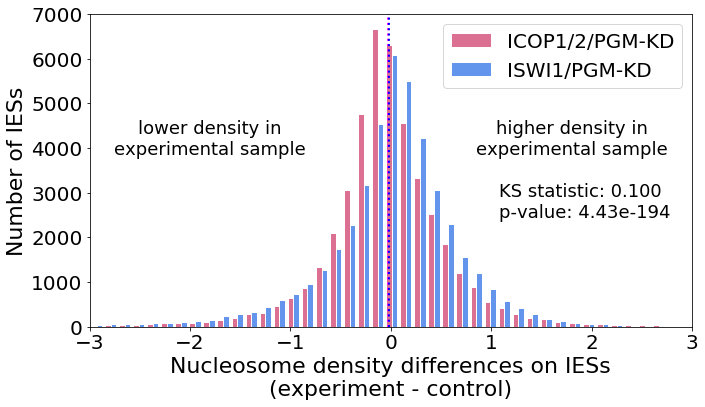

In [12]:
hist_tot_nuc_diff(df2, 'ICOP', 'ISWI', ['ICOP1/2/PGM-KD','ISWI1/PGM-KD'], ['palevioletred','cornflowerblue'],\
['magenta','blue'], save = True)

0.03255165274846693 -0.039449937394987505
43410 44257


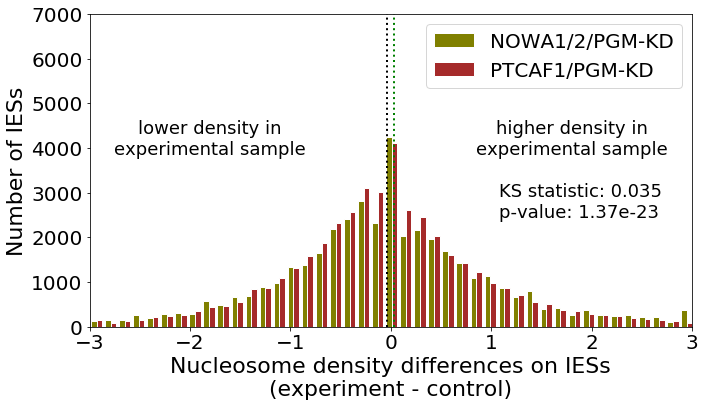

In [13]:
hist_tot_nuc_diff(df2, 'NOWA', 'PTCAF', ['NOWA1/2/PGM-KD','PTCAF1/PGM-KD'], ['olive','brown'],\
                 ['green','black'], save = True)

-0.02931505038365063 -0.039449937394987505
44449 44257


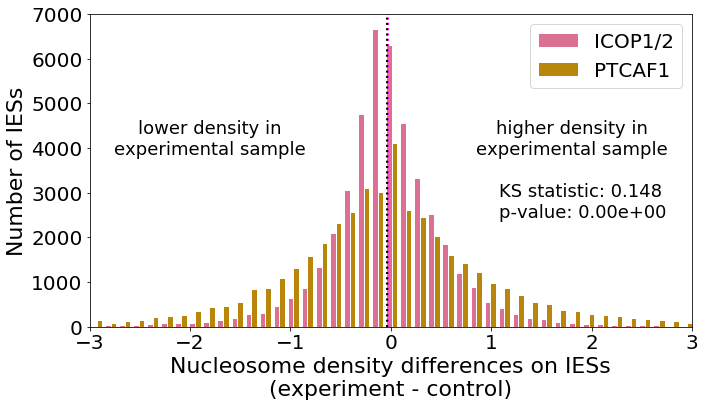

In [14]:
hist_tot_nuc_diff(df2, 'ICOP', 'PTCAF', ['ICOP1/2','PTCAF1'], ['palevioletred','darkgoldenrod'],\
                 ['magenta','black'])

-0.02931505038365063 0.03255165274846693
44449 43410


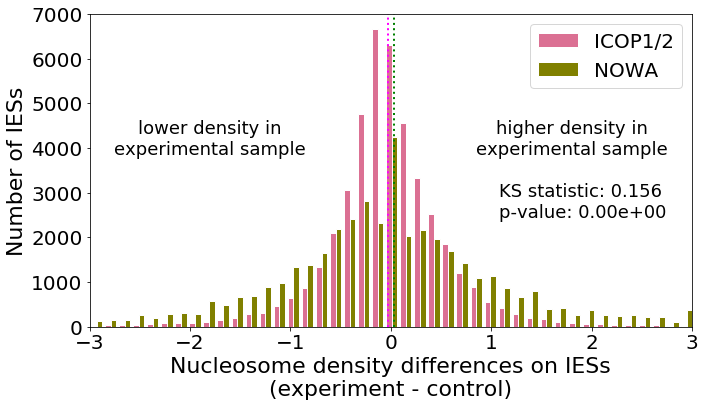

In [15]:
hist_tot_nuc_diff(df2, 'ICOP', 'NOWA', ['ICOP1/2','NOWA'], ['palevioletred','olive'],\
                 ['magenta','green'])

In [16]:
def hist_nuc_diff(df, dataset1, dataset2, IRS_KD, labels, colors, meancol,\
                  IRS_threshold=0.2, len_threshold=200, save=False):
    """
    histograms for nucleosome density difference subsets according to IES length and IRS threshold
    
    Keyword arguments:
    df -- data frame containing all values (e.g. df2)
    dataset1 -- string defining first dataset of interest. String needs to match the 
              nucleosome density difference column name in the data frame; includes 
              experimental and control sample (e.g. 'ICOP' for "ICOP_re-rc")
    dataset2 -- string defining second dataset of interest. String needs to match the 
              nucleosome density difference column name in the data frame; includes 
              experimental and control sample (e.g. 'ISWI' for "ISWI_re-rc")
    IRS_KD -- string defining column in the data frame containing IRSs (IES retention scores) that should 
            be used for filtering highly or lowly retained IESs (e.g. 'ICOP1_2_IRS'). If no filtering for IRS
            is applied, procide any argument (will not be used)
    IRS_threshold -- flaot (0 to 1) defining IESs considered with low (IES retention < IRS_threshold) 
                   or high retention (IES retention >= IRS_threshold). 
                   If no threshold should be applied use None 
                   (default 0.2)
    len_threshold -- integer (higher 0) defining IES considered short (IES length < len_threshold) 
                   or long (IES length >= len_threshold). 
                   If no threshold should be applied use None 
                   (default 200)
    
    return values:
    none
    the function will generate a histogram. If Save = True it will save the image as .pdf file
    
    """
    
    # retrieve the subsets
    subs1 = select_subsets_diff(df, dataset1, IRS_KD, IRS_threshold, len_threshold)
    subs2 = select_subsets_diff(df, dataset2, IRS_KD, IRS_threshold, len_threshold)
    ks_stats = ks_statistics_diff(df, dataset1, dataset2, IRS_KD, IRS_threshold, len_threshold) 
    
    IRS_KD_label = f"{IRS_KD}".replace("_","/")
    
    fig, axes = plt.subplots(4, 2, figsize=(12,10))
    ax1, ax2 = axes[0]
    ax3, ax4 = axes[1]
    ax5, ax6 = axes[2]
    ax7, ax8 = axes[3]
    
    
    ax1.hist((subs1['low'], subs2['low']), bins=np.linspace(-3, 4, 51), 
              color=colors, ec = 'white', lw=1, label=labels)
    ax1.set_title(f"low\n{IRS_KD_label} IRS < {IRS_threshold}", fontsize=14)

    ax2.hist((subs1['high'], subs2['high']), bins=np.linspace(-3, 4, 51), 
              color=colors, ec = 'white', lw=1, label=labels)
    ax2.set_title(f"high\n{IRS_KD_label} IRS >= {IRS_threshold}", fontsize=14)

    ax3.hist((subs1['short'], subs2['short']), bins=np.linspace(-3, 4, 51),
             color=colors, ec = 'white', lw=1, label=labels)
    ax3.set_title(f"short\nIES length < {len_threshold} bp", fontsize=14)

    ax4.hist((subs1['long'], subs2['long']), bins=np.linspace(-3, 4, 51),
             color=colors, ec = 'white', lw=1, label=labels)
    ax4.set_title(f"long\nIES length >= {len_threshold} bp", fontsize=14)

    ax5.hist((subs1['low_short'], subs2['low_short']), bins=np.linspace(-3, 4, 51),
             color=colors, ec = 'white', lw=1, label=labels)
    ax5.set_title(f"low_short\n{IRS_KD_label} IRS < {IRS_threshold}, IES length < {len_threshold} bp", 
                  fontsize=14)

    ax6.hist((subs1['high_short'], subs2['high_short']), bins=np.linspace(-3, 4, 51),
             color=colors, ec = 'white', lw=1, label=labels)
    ax6.set_title(f"high_short\n{IRS_KD_label} IRS >= {IRS_threshold}, IES length < {len_threshold} bp", 
                  fontsize=14)

    ax7.hist((subs1['low_long'], subs2['low_long']), bins=np.linspace(-3, 4, 51),
             color=colors, ec = 'white', lw=1, label=labels)
    ax7.set_title(f"low_long\n{IRS_KD_label} IRS < {IRS_threshold}, IES length >= {len_threshold} bp", 
                  fontsize=14)

    ax8.hist((subs1['high_long'], subs2['high_long']), bins=np.linspace(-3, 4, 51),
             color=colors, ec = 'white', lw=1, label=labels)
    ax8.set_title(f"high_long\n{IRS_KD_label} IRS >= {IRS_threshold}, IES length >= {len_threshold} bp", 
                  fontsize=14)

    # set x-axis limits
    ax1.set_xlim([-3,3])
    ax2.set_xlim([-3,3])
    ax3.set_xlim([-3,3])
    ax4.set_xlim([-3,3])
    ax5.set_xlim([-3,3])
    ax6.set_xlim([-3,3])
    ax7.set_xlim([-3,3])
    ax8.set_xlim([-3,3])

    # set the font size of the axis ticks
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    ax4.tick_params(axis='both', which='major', labelsize=14)
    ax5.tick_params(axis='both', which='major', labelsize=14)
    ax6.tick_params(axis='both', which='major', labelsize=14)
    ax7.tick_params(axis='both', which='major', labelsize=14)
    ax8.tick_params(axis='both', which='major', labelsize=14)


    # include KS-statistic
    text_pos = (0.015,0.29)
    ax1.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['low_ks'][0], ks_stats['low_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax2.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['high_ks'][0], ks_stats['high_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax3.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['short_ks'][0], ks_stats['short_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax4.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['long_ks'][0], ks_stats['long_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax5.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['low_short_ks'][0], ks_stats['low_short_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax6.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['high_short_ks'][0], ks_stats['high_short_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax7.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['low_long_ks'][0], ks_stats['low_long_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    ax8.annotate('KS statistic: %.3f\np-value: %.2e' % (ks_stats['high_long_ks'][0], ks_stats['high_long_ks'][1]),
                xy = text_pos,xycoords='axes fraction',fontsize=13)
    
    # include medians as lines for dataset1
    ax1.axvline(x=np.mean(subs1['low']), ymin=0, ymax=4000, ls=':', color=meancol[0], lw=1.5)
    ax2.axvline(x=np.mean(subs1['high']), ymin=0, ymax=4000, ls=':', color=meancol[0], lw=1.5)
    ax3.axvline(x=np.mean(subs1['short']), ymin=0, ymax=4000, ls=':', color=meancol[0], lw=1.5)
    ax4.axvline(x=np.mean(subs1['long']), ymin=0, ymax=4000, ls=':', color=meancol[0], lw=1.5)
    ax5.axvline(x=np.mean(subs1['low_short']), ymin=0, ymax=4000, ls=':', color=meancol[0], lw=1.5)
    ax6.axvline(x=np.mean(subs1['high_short']), ymin=0, ymax=4000, ls=':', color=meancol[0], lw=1.5)
    ax7.axvline(x=np.mean(subs1['low_long']), ymin=0, ymax=4000, ls=':', color=meancol[0], lw=1.5)
    ax8.axvline(x=np.mean(subs1['high_long']), ymin=0, ymax=4000, ls=':', color=meancol[0], lw=1.5)

    # include medians as lines for dataset2
    ax1.axvline(x=np.mean(subs2['low']), ymin=0, ymax=4000, ls=':', color=meancol[1], lw=1.5)
    ax2.axvline(x=np.mean(subs2['high']), ymin=0, ymax=4000, ls=':', color=meancol[1], lw=1.5)
    ax3.axvline(x=np.mean(subs2['short']), ymin=0, ymax=4000, ls=':', color=meancol[1], lw=1.5)
    ax4.axvline(x=np.mean(subs2['long']), ymin=0, ymax=4000, ls=':', color=meancol[1], lw=1.5)
    ax5.axvline(x=np.mean(subs2['low_short']), ymin=0, ymax=4000, ls=':', color=meancol[1], lw=1.5)
    ax6.axvline(x=np.mean(subs2['high_short']), ymin=0, ymax=4000, ls=':', color=meancol[1], lw=1.5)
    ax7.axvline(x=np.mean(subs2['low_long']), ymin=0, ymax=4000, ls=':', color=meancol[1], lw=1.5)
    ax8.axvline(x=np.mean(subs2['high_long']), ymin=0, ymax=4000, ls=':', color=meancol[1], lw=1.5)


    #ax2.legend(bbox_to_anchor=(0.6, 1.03), fontsize=13, framealpha=1)
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.51, 1.02), fontsize=13)


    fig.text(0.5, 0.001, 'Nucleosome density differences on IESs\n(experiment - control)', ha='center', 
         fontsize=16)
    fig.text(0.17, 0.9, 'lower density in\nexperimental sample', ha='center', wrap=True, fontsize=13)
    fig.text(0.38, 0.9, 'higher density in\nexperimental sample', ha='center', wrap=True, fontsize=13)
    fig.text(0.00001, 0.5, 'Number of IESs', ha='center', fontsize=16, rotation='vertical')


    fig.tight_layout(rect=[0.01, 0.04, 1, 1])
    
    if save:
        fig.savefig(f"{dataset1}_{dataset2}_{IRS_KD}_{IRS_threshold}_{len_threshold}_subsNu-diff.pdf",\
                    bbox_inches = 'tight')
        
    

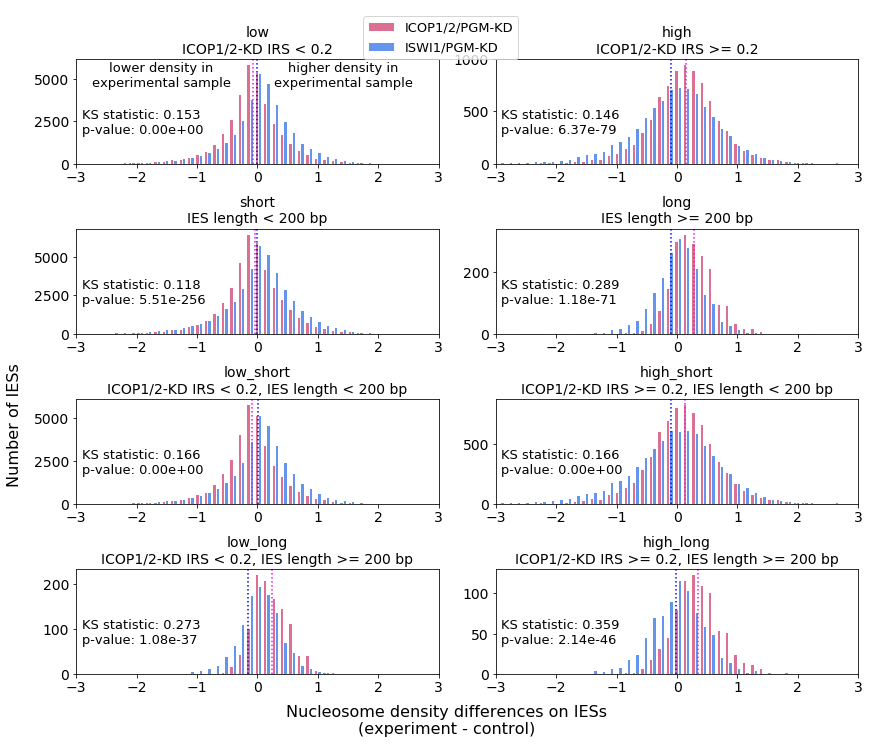

In [17]:
hist_nuc_diff(df2,'ICOP','ISWI','ICOP1_2-KD',['ICOP1/2/PGM-KD','ISWI1/PGM-KD'], \
              ['palevioletred','cornflowerblue'],\
              ['magenta','blue'], IRS_threshold=0.2,len_threshold=200, save=True)

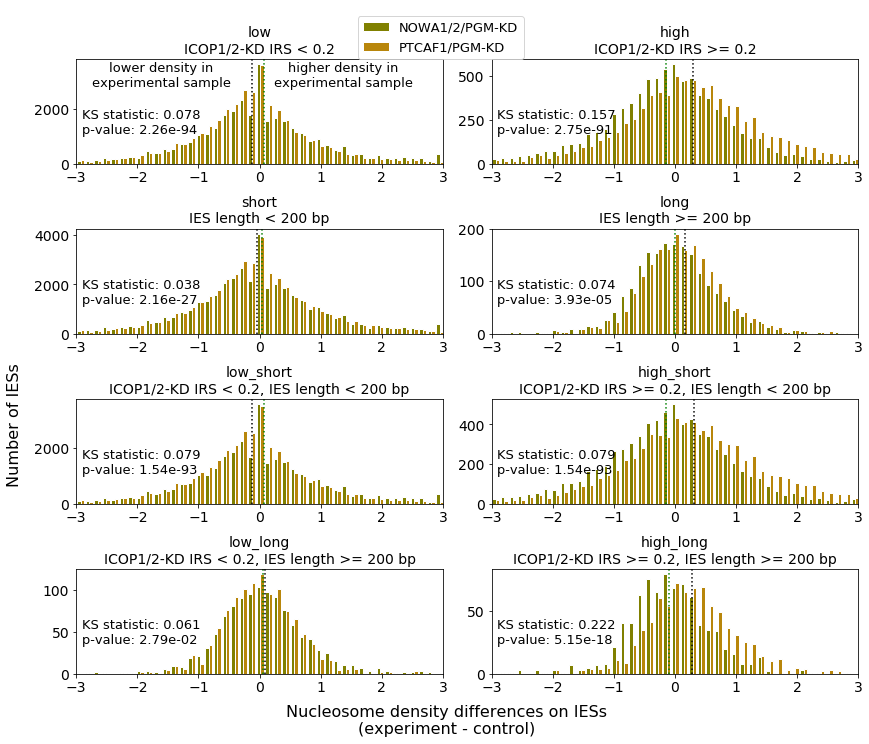

In [18]:
hist_nuc_diff(df2,'NOWA','PTCAF','ICOP1_2-KD',['NOWA1/2/PGM-KD','PTCAF1/PGM-KD'], \
              ['olive','darkgoldenrod'],\
              ['green','black'], IRS_threshold=0.2,len_threshold=200, save=True)

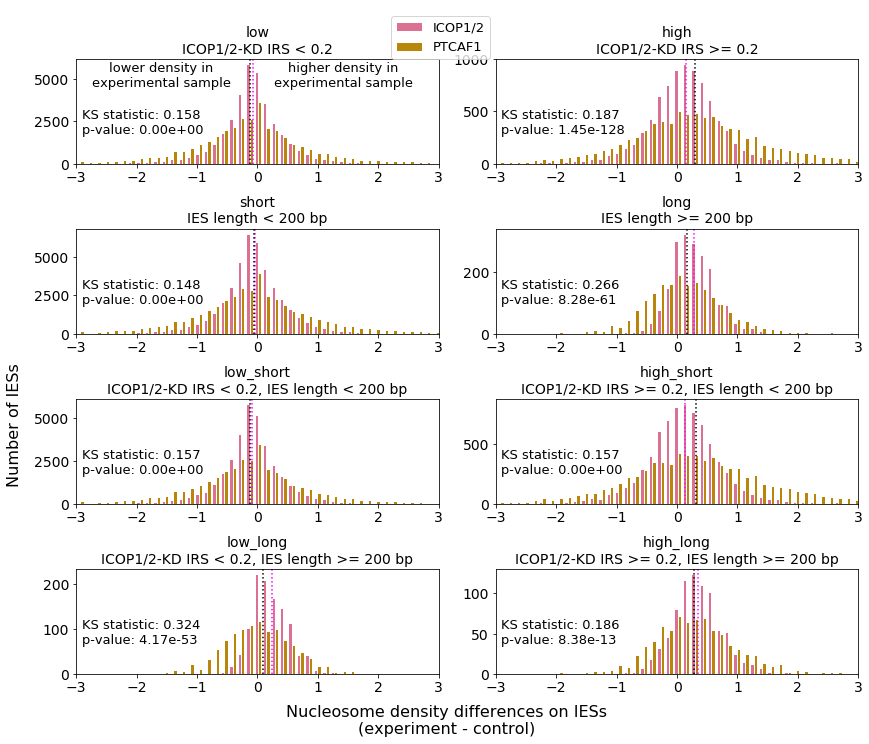

In [19]:
hist_nuc_diff(df2,'ICOP','PTCAF','ICOP1_2-KD',['ICOP1/2','PTCAF1'], ['palevioletred','darkgoldenrod'],\
              ['magenta','black'], IRS_threshold=0.2,len_threshold=200,save=False)

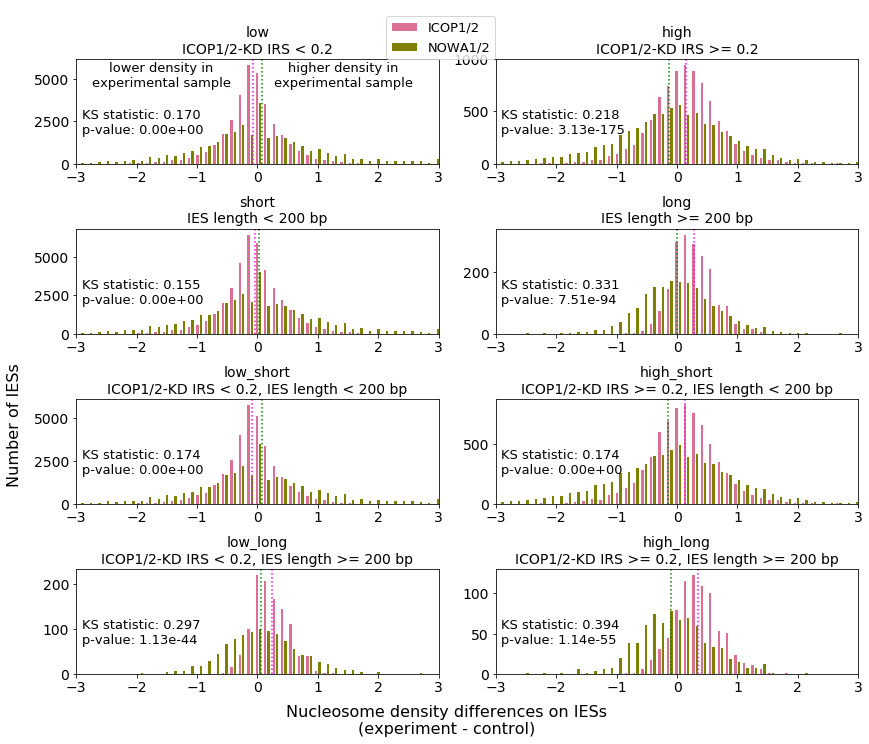

In [20]:
hist_nuc_diff(df2,'ICOP','NOWA','ICOP1_2-KD',['ICOP1/2','NOWA1/2'], ['palevioletred','olive'],\
              ['magenta','green'], IRS_threshold=0.2,len_threshold=200,save=False)

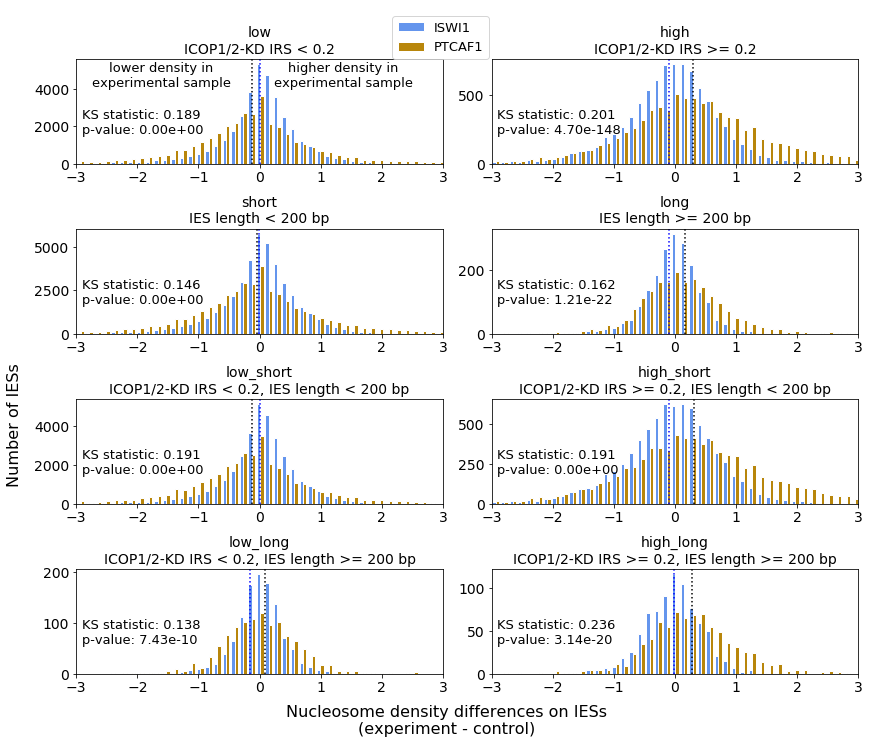

In [21]:
hist_nuc_diff(df2,'ISWI','PTCAF','ICOP1_2-KD',['ISWI1','PTCAF1'], ['cornflowerblue','darkgoldenrod'],\
              ['blue','black'], IRS_threshold=0.2,len_threshold=200,save=False)

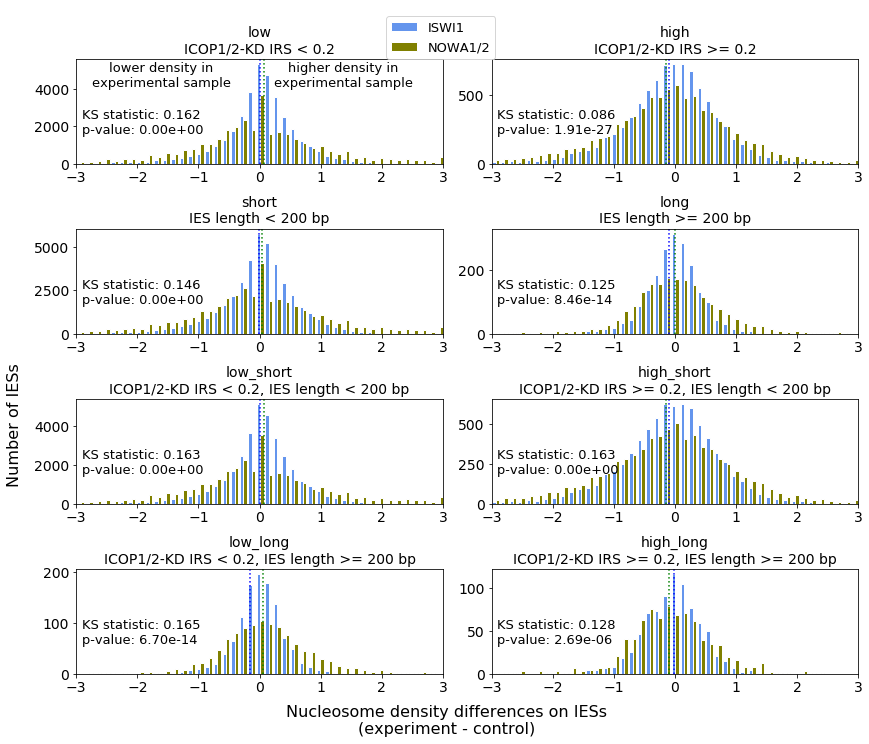

In [22]:
hist_nuc_diff(df2,'ISWI','NOWA','ICOP1_2-KD',['ISWI1','NOWA1/2'], ['cornflowerblue','olive'],\
              ['blue','green'], IRS_threshold=0.2,len_threshold=200,save=False)

In [31]:
df2.columns.values

array(['IES_length', 'ND7_PGM_DNase', 'ND7_PGM_MAC', 'ICOP1_2_PGM_DNase',
       'ICOP1_2_PGM_MAC', 'PGM_MAC', 'Pg18', 'ISW_PGM_MAC', 'I1Pg18',
       'EV_PGM_N1_MP', 'EV_Pg', 'N1Pgm_N1_MP', 'NOWA1_Pg', 'EV_PGM_MP',
       'EV_PGM_NP', 'PtCAF1_PGM_MP', 'PtCAF1_PGM_NP', 'ICOP1_2-KD',
       'ICOP_r_c', 'ICOP_r_e', 'ICOP_re-rc', 'ISWI_r_c', 'ISWI_r_e',
       'ISWI_re-rc', 'NOWA_r_c', 'NOWA_r_e', 'NOWA_re-rc', 'PTCAF_r_c',
       'PTCAF_r_e', 'PTCAF_re-rc'], dtype=object)

In [24]:
hist_nuc_diff(df2,'ICOP','ISWI','ISWI1-KD',['ICOP1/2','PTCAF1'], ['palevioletred','cornflowerblue'],\
              ['magenta','blue'], IRS_threshold=0.2,len_threshold=200,save=False)

KeyError: 'ISWI1-KD'

In [ ]:
hist_nuc_diff(df2,'ICOP','PTCAF','ISWI1-KD',['ICOP1/2','PTCAF1'], ['palevioletred','darkgoldenrod'],\
              ['magenta','black'], IRS_threshold=0.2,len_threshold=200,save=False)

In [ ]:
hist_nuc_diff(df2,'ICOP','ISWI','ICOP1_2-KD',['ICOP1/2','ISWI1'], ['palevioletred','cornflowerblue'],\
              ['magenta','blue'], IRS_threshold=0.2,len_threshold=150,save=False)

In [ ]:
hist_nuc_diff(df2,'ICOP','PTCAF','ICOP1_2-KD',['ICOP1/2','PTCAF1'], ['palevioletred','darkgoldenrod'],\
              ['magenta','black'], IRS_threshold=0.2,len_threshold=150,save=False)